# Data Dictionary

## [Link to download dataset!](https://www.kaggle.com/datasets/dgawlik/nyse)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-za14{border-color:inherit;text-align:left;vertical-align:bottom}
.tg .tg-7zrl{text-align:left;vertical-align:bottom}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-za14">Field Name</th>
    <th class="tg-7zrl">Description</th>
    <th class="tg-7zrl">Data Type</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-7zrl">date</td>
    <td class="tg-7zrl">The date range for each data entry. This appears to be a combined string of start and end dates.</td>
    <td class="tg-7zrl">Text</td>
  </tr>
  <tr>
    <td class="tg-7zrl">DateTimeCount</td>
    <td class="tg-7zrl">The count of DateTime entries within the specified date range.</td>
    <td class="tg-7zrl">Numeric (Integer)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">symbol</td>
    <td class="tg-7zrl">An identifier or code, possibly for a financial instrument or category.</td>
    <td class="tg-7zrl">Text</td>
  </tr>
  <tr>
    <td class="tg-7zrl">open</td>
    <td class="tg-7zrl">The opening price/value for a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">close</td>
    <td class="tg-7zrl">The closing price/value for a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">low</td>
    <td class="tg-7zrl">The lowest price/value recorded within a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">high</td>
    <td class="tg-7zrl">The highest price/value recorded within a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">volume</td>
    <td class="tg-7zrl">The trading volume (number of units traded) within a given period.</td>
    <td class="tg-7zrl">Numeric (Integer)</td>
  </tr>
</tbody></table>

# Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler

# Suppress the specific FutureWarning from seaborn._oldcore
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn._oldcore')

2025-07-24 14:04:05.272769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753365845.484503      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753365845.548756      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [3]:
df = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


# Split dataset into train and test

In [4]:
# --- Chronological Split ---
# First, ensure the DataFrame is sorted by date
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

test_size_ratio = 0.2 # 20% for test set
split_point = int(len(df) * (1 - test_size_ratio))

train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

print("\nData split chronologically by 'date' column:")
print(f"Train DataFrame shape: {train.shape}")
print(f"Test DataFrame shape: {test.shape}")


Data split chronologically by 'date' column:
Train DataFrame shape: (681011, 7)
Test DataFrame shape: (170253, 7)


In [5]:
# Sort train dataframe based on date column from less value to more value
train = train.sort_values(by='date').reset_index(drop=True)
test = test.sort_values(by='date').reset_index(drop=True)

# Data Visualization

## Select one stock for creating model

In [6]:
train = train[train.symbol == 'EQIX'].copy()
test = test[test.symbol == 'EQIX'].copy()
# Sort train dataframe based on date column from less value to more value
train = train.sort_values(by='date').reset_index(drop=True)
test = test.sort_values(by='date').reset_index(drop=True)
train

,date,symbol,open,close,low,high,volume
0,2010-01-04,EQIX,106.519997,109.559998,106.510002,109.620003,576300.0
1,2010-01-05,EQIX,109.589996,108.540001,108.379997,109.589996,681900.0
2,2010-01-06,EQIX,108.949997,109.529999,108.220001,110.570000,1397500.0
3,2010-01-07,EQIX,109.250000,107.290001,106.639999,110.349998,797200.0
4,2010-01-08,EQIX,106.800003,106.769997,105.900002,107.279999,432400.0
...,...,...,...,...,...,...,...
1417,2015-08-20,EQIX,284.220001,279.959991,279.920013,284.649994,568700.0
1418,2015-08-21,EQIX,277.160004,271.309998,271.309998,279.790009,1271900.0
1419,2015-08-24,EQIX,260.000000,255.529999,251.000000,267.089996,1306700.0
1420,2015-08-25,EQIX,260.309998,251.110001,250.860001,263.670013,1294200.0


## Basic Information

In [7]:
train.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,EQIX,106.519997,109.559998,106.510002,109.620003,576300.0
1,2010-01-05,EQIX,109.589996,108.540001,108.379997,109.589996,681900.0
2,2010-01-06,EQIX,108.949997,109.529999,108.220001,110.570000,1397500.0
3,2010-01-07,EQIX,109.250000,107.290001,106.639999,110.349998,797200.0
4,2010-01-08,EQIX,106.800003,106.769997,105.900002,107.279999,432400.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1422 non-null   object 
 1   symbol  1422 non-null   object 
 2   open    1422 non-null   float64
 3   close   1422 non-null   float64
 4   low     1422 non-null   float64
 5   high    1422 non-null   float64
 6   volume  1422 non-null   float64
dtypes: float64(5), object(2)
memory usage: 77.9+ KB


In [9]:
train.describe()

,open,close,low,high,volume
count,1422.000000,1422.000000,1422.000000,1422.000000,1.422000e+03
mean,160.671779,160.734803,158.748868,162.544423,9.128723e+05
std,57.769144,57.761722,57.255626,58.169847,1.064773e+06
min,71.750000,70.339996,69.419998,74.510002,1.524000e+05
25%,98.382502,98.502500,97.042500,99.649997,5.338000e+05
50%,173.614998,173.385002,170.770004,176.120003,7.309500e+05
75%,210.034996,210.097504,208.022495,212.072502,1.040200e+06
max,286.130005,287.420013,283.980011,288.500000,3.057420e+07


## Trend of stock

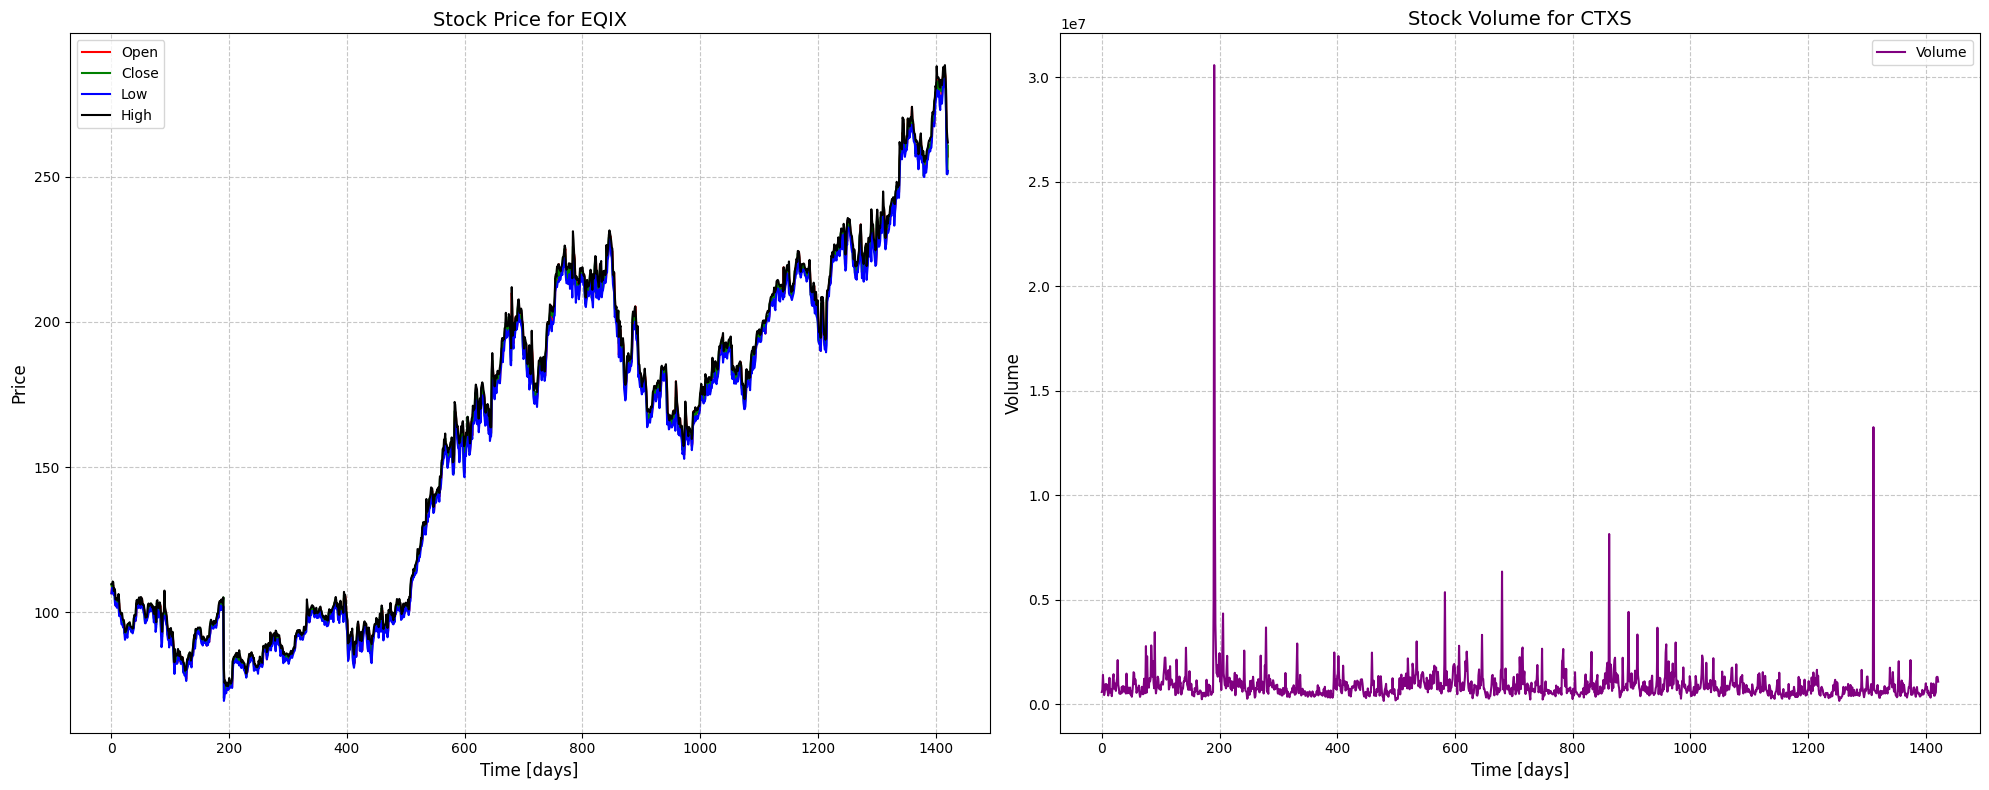

In [10]:
# For plotting, it's often easier to use a numerical index for 'time [days]'
train['time_idx'] = range(len(train))

# Filter the DataFrame for the 'CTXS' symbol
ctxs_data = train[train.symbol == 'EQIX']

# --- Plotting with Seaborn ---
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Adjusted figure size for better side-by-side view

# Subplot 1: Stock Prices
# Use sns.lineplot for each price type
sns.lineplot(x='time_idx', y='open', data=ctxs_data, color='red', label='Open', ax=axes[0])
sns.lineplot(x='time_idx', y='close', data=ctxs_data, color='green', label='Close', ax=axes[0])
sns.lineplot(x='time_idx', y='low', data=ctxs_data, color='blue', label='Low', ax=axes[0])
sns.lineplot(x='time_idx', y='high', data=ctxs_data, color='black', label='High', ax=axes[0])

axes[0].set_title('Stock Price for EQIX', fontsize=14)
axes[0].set_xlabel('Time [days]', fontsize=12)
axes[0].set_ylabel('Price', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, linestyle='--', alpha=0.7) # Add grid for better readability

# Subplot 2: Stock Volume
sns.lineplot(x='time_idx', y='volume', data=ctxs_data, color='purple', label='Volume', ax=axes[1]) # Changed color for distinction

axes[1].set_title('Stock Volume for CTXS', fontsize=14)
axes[1].set_xlabel('Time [days]', fontsize=12)
axes[1].set_ylabel('Volume', fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(True, linestyle='--', alpha=0.7) # Add grid for better readability

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Correlation analysis

In [11]:
train = train.drop(columns=['symbol'])
test = test.drop(columns=['symbol'])
train

,date,open,close,low,high,volume,time_idx
0,2010-01-04,106.519997,109.559998,106.510002,109.620003,576300.0,0
1,2010-01-05,109.589996,108.540001,108.379997,109.589996,681900.0,1
2,2010-01-06,108.949997,109.529999,108.220001,110.570000,1397500.0,2
3,2010-01-07,109.250000,107.290001,106.639999,110.349998,797200.0,3
4,2010-01-08,106.800003,106.769997,105.900002,107.279999,432400.0,4
...,...,...,...,...,...,...,...
1417,2015-08-20,284.220001,279.959991,279.920013,284.649994,568700.0,1417
1418,2015-08-21,277.160004,271.309998,271.309998,279.790009,1271900.0,1418
1419,2015-08-24,260.000000,255.529999,251.000000,267.089996,1306700.0,1419
1420,2015-08-25,260.309998,251.110001,250.860001,263.670013,1294200.0,1420


In [12]:
# Convert date to datetime format
train['date'] = pd.to_datetime(train['date'])

# Extract numerical features from datetime
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train

,date,open,close,low,high,volume,time_idx,year,month,day
0,2010-01-04,106.519997,109.559998,106.510002,109.620003,576300.0,0,2010,1,4
1,2010-01-05,109.589996,108.540001,108.379997,109.589996,681900.0,1,2010,1,5
2,2010-01-06,108.949997,109.529999,108.220001,110.570000,1397500.0,2,2010,1,6
3,2010-01-07,109.250000,107.290001,106.639999,110.349998,797200.0,3,2010,1,7
4,2010-01-08,106.800003,106.769997,105.900002,107.279999,432400.0,4,2010,1,8
...,...,...,...,...,...,...,...,...,...,...
1417,2015-08-20,284.220001,279.959991,279.920013,284.649994,568700.0,1417,2015,8,20
1418,2015-08-21,277.160004,271.309998,271.309998,279.790009,1271900.0,1418,2015,8,21
1419,2015-08-24,260.000000,255.529999,251.000000,267.089996,1306700.0,1419,2015,8,24
1420,2015-08-25,260.309998,251.110001,250.860001,263.670013,1294200.0,1420,2015,8,25


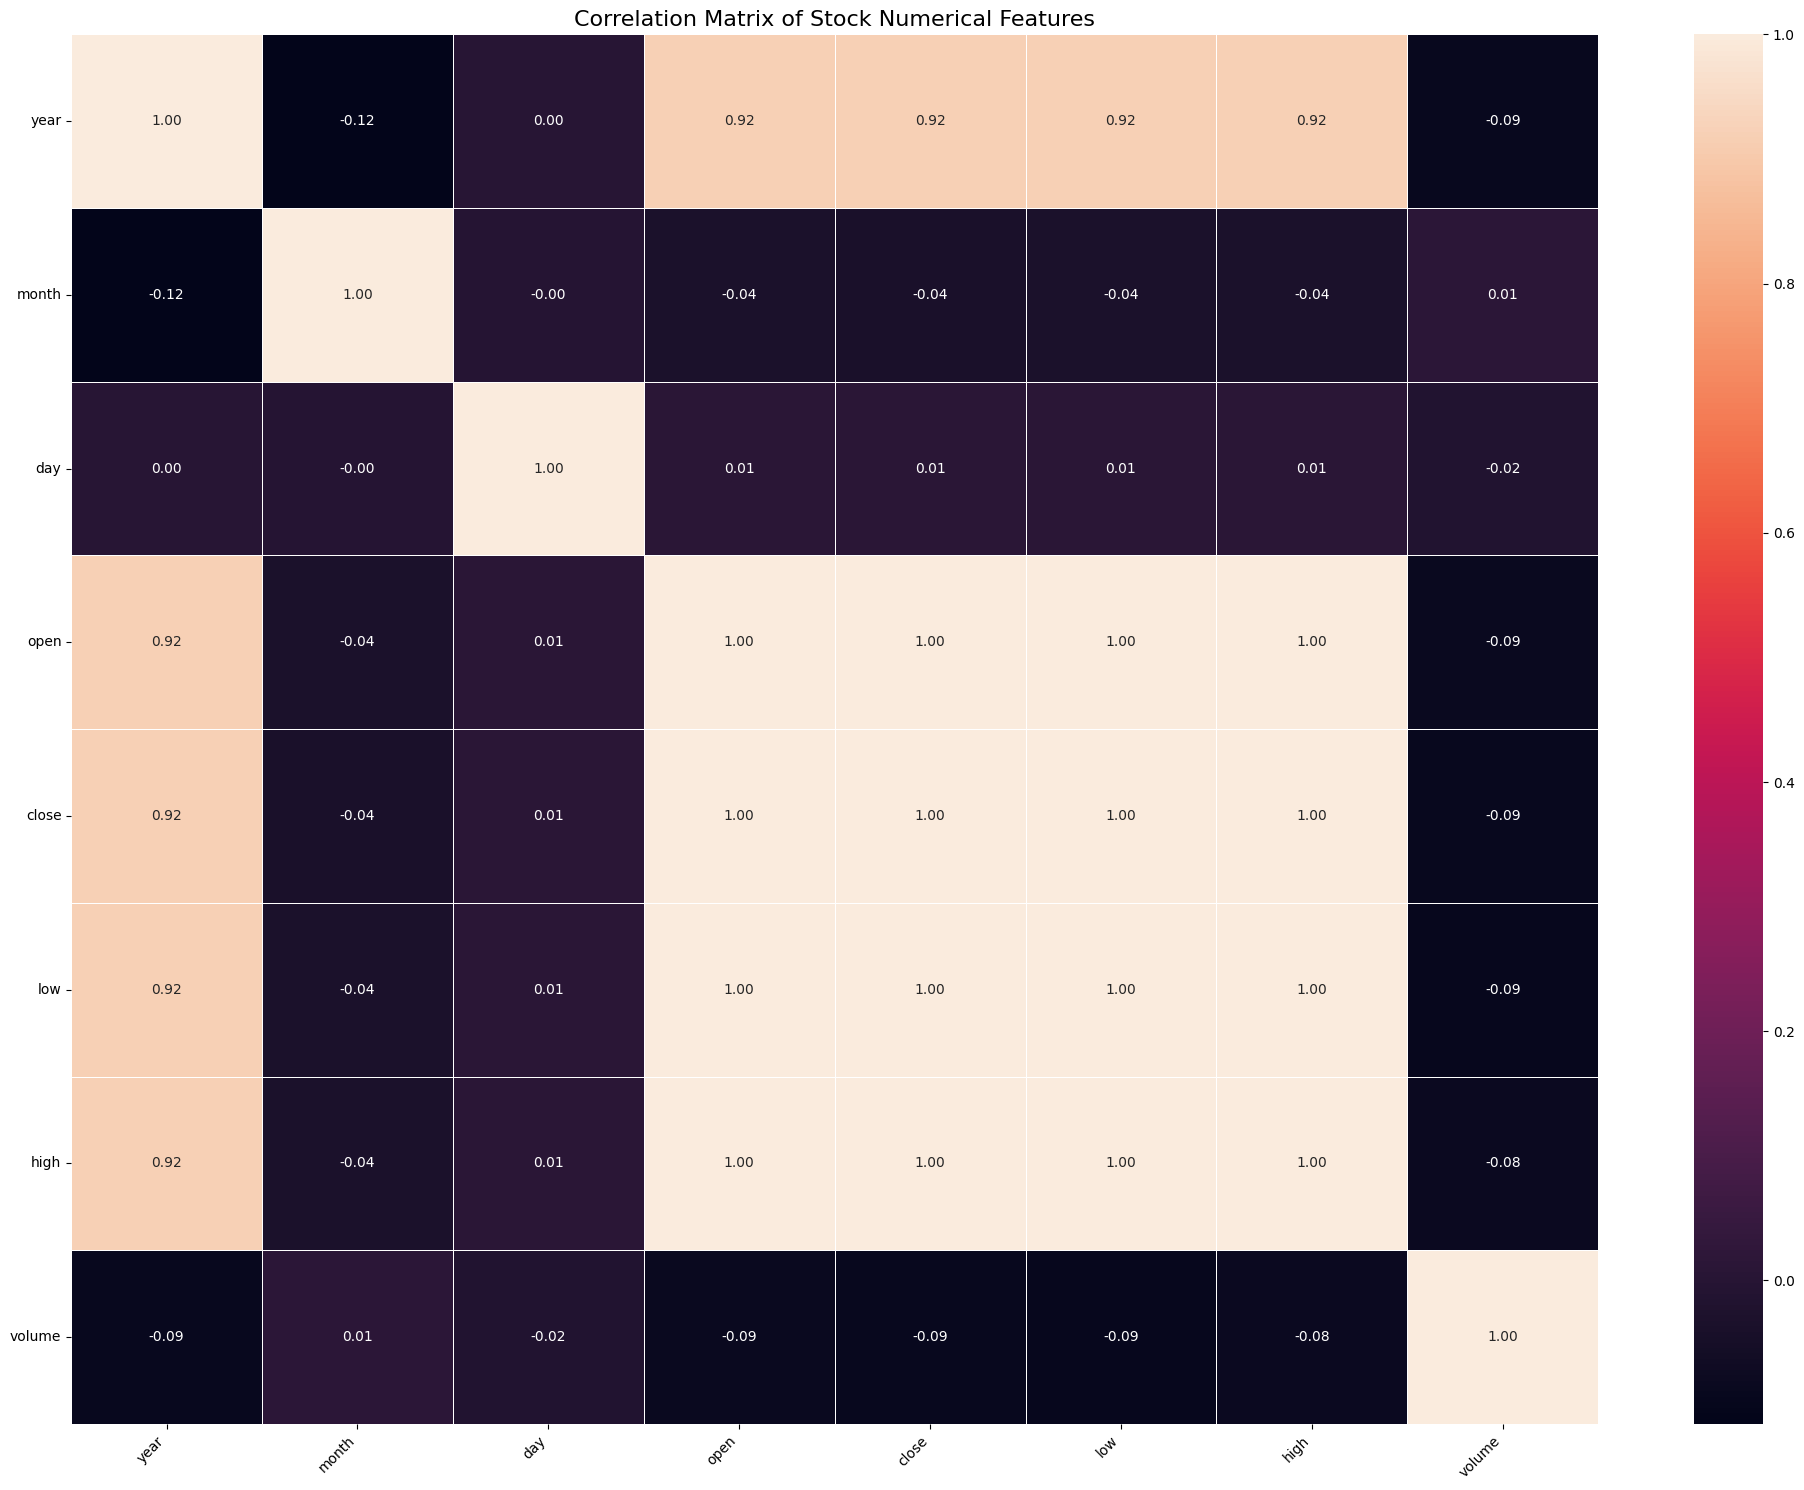


--- Interpretation of the Correlation Heatmap ---
• Values close to 1 indicate a strong positive correlation (as one variable increases, the other tends to increase).
• Values close to -1 indicate a strong negative correlation (as one variable increases, the other tends to decrease).
• Values close to 0 indicate a weak or no linear correlation.
• The diagonal is always 1 because a variable is perfectly correlated with itself.


In [13]:
# Select numerical columns for correlation
numerical_cols = ['year','month','day', 'open', 'close', 'low', 'high', 'volume']

# Calculate Pearson correlation
correlation_matrix = train[numerical_cols].corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 15)) # Set a suitable figure size for the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,      # Show the correlation values on the heatmap
    cmap='rocket', # Colormap: 'coolwarm' is good for showing positive/negative
    fmt=".2f",       # Format annotations to two decimal places
    linewidths=.5    # Add lines between cells
)
plt.title('Correlation Matrix of Stock Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\n--- Interpretation of the Correlation Heatmap ---")
print("• Values close to 1 indicate a strong positive correlation (as one variable increases, the other tends to increase).")
print("• Values close to -1 indicate a strong negative correlation (as one variable increases, the other tends to decrease).")
print("• Values close to 0 indicate a weak or no linear correlation.")
print("• The diagonal is always 1 because a variable is perfectly correlated with itself.")

# Data Preprocessing

## Encode date

In [14]:
# Convert date to datetime format
test['date'] = pd.to_datetime(test['date'])

# Extract numerical features from datetime
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test

,date,open,close,low,high,volume,year,month,day
0,2015-08-27,262.089996,266.140015,261.519989,268.179993,704700.0,2015,8,27
1,2015-08-28,264.709991,268.779999,264.489990,270.000000,588600.0,2015,8,28
2,2015-08-31,267.519989,269.769989,265.000000,270.100006,4911600.0,2015,8,31
3,2015-09-01,265.089996,262.869995,260.429993,266.769989,1298200.0,2015,9,1
4,2015-09-02,264.989990,269.950012,263.619995,269.980011,1049100.0,2015,9,2
...,...,...,...,...,...,...,...,...,...
335,2016-12-23,352.100006,356.609985,350.369995,358.140015,338100.0,2016,12,23
336,2016-12-27,356.779999,356.720001,355.109985,359.649994,294600.0,2016,12,27
337,2016-12-28,357.220001,353.859985,353.429993,359.549988,291600.0,2016,12,28
338,2016-12-29,353.420013,357.089996,351.890015,358.929993,372000.0,2016,12,29


In [15]:
train = train.drop(columns=['day','date','time_idx'])
test = test.drop(columns=['day','date'])
train

,open,close,low,high,volume,year,month
0,106.519997,109.559998,106.510002,109.620003,576300.0,2010,1
1,109.589996,108.540001,108.379997,109.589996,681900.0,2010,1
2,108.949997,109.529999,108.220001,110.570000,1397500.0,2010,1
3,109.250000,107.290001,106.639999,110.349998,797200.0,2010,1
4,106.800003,106.769997,105.900002,107.279999,432400.0,2010,1
...,...,...,...,...,...,...,...
1417,284.220001,279.959991,279.920013,284.649994,568700.0,2015,8
1418,277.160004,271.309998,271.309998,279.790009,1271900.0,2015,8
1419,260.000000,255.529999,251.000000,267.089996,1306700.0,2015,8
1420,260.309998,251.110001,250.860001,263.670013,1294200.0,2015,8


## Data Normalization

In [16]:
# --- Min-Max Scaling of Numerical Columns ---
print("\n--- Applying Min-Max Scaling to Numerical Features ---")

numerical_cols = ['open', 'close', 'low', 'high', 'volume']
scaler = MinMaxScaler()

# Fit the scaler on the training data's numerical columns and transform them
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
print("Train DataFrame numerical columns scaled.")

# Transform the test data's numerical columns using the *fitted* scaler
test[numerical_cols] = scaler.transform(test[numerical_cols])
print("Test DataFrame numerical columns transformed.")


--- Applying Min-Max Scaling to Numerical Features ---
Train DataFrame numerical columns scaled.
Test DataFrame numerical columns transformed.


## Create Train, Validation, and Test Data Sequence

In [17]:
# Define percentages for data splitting.
# These percentages are used to determine the sizes of validation sets.
valid_set_size_percentage = 20 # 20% of the training sequences will be used for validation
test_set_size_percentage = 10 # This variable is not directly used for slicing in the current functions,
                              # but is kept for context from the original snippet.

# Function to create train and validation data sequences given stock data and sequence length
def load_data_train(stock, seq_len, valid_set_size_percentage):
    """
    Converts a DataFrame into sequences for training and validation.

    Args:
        stock (pd.DataFrame): The input DataFrame (e.g., your 'train' DataFrame).
        seq_len (int): The length of each sequence.
        valid_set_size_percentage (int): Percentage of data to reserve for validation.

    Returns:
        list: [x_train, y_train, x_valid, y_valid]
              x_train: Training input sequences.
              y_train: Training target values (next step in sequence).
              x_valid: Validation input sequences.
              y_valid: Validation target values (next step in sequence).
    """
    # Fix: .as_matrix() is deprecated, use .values to convert DataFrame to NumPy array
    data_raw = stock.values
    data = []

    # Create all possible sequences of length seq_len
    # Each sequence will be [data_raw[index], ..., data_raw[index + seq_len - 1]]
    # and the target will be data_raw[index + seq_len]
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len + 1]) # Include the target in the sequence initially

    data = np.array(data)

    # Calculate validation set size based on the generated sequences
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * data.shape[0]))
    train_set_size = data.shape[0] - valid_set_size

    # Split data into training and validation sets
    # x_train contains sequences of length seq_len
    # y_train contains the next value after each sequence
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size + valid_set_size, -1, :]

    return [x_train, y_train, x_valid, y_valid]

# Function to create test data sequences given stock data and sequence length
def load_data_test(stock, seq_len):
    """
    Converts a DataFrame into sequences for testing.

    Args:
        stock (pd.DataFrame): The input DataFrame (e.g., your 'test' DataFrame).
        seq_len (int): The length of each sequence.

    Returns:
        list: [x_test, y_test]
              x_test: Test input sequences.
              y_test: Test target values (next step in sequence).
    """
    # Fix: .as_matrix() is deprecated, use .values
    data_raw = stock.values
    data = []

    # Create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len + 1]) # Include the target in the sequence initially

    data = np.array(data)

    # Fix: For test data, we take all sequences generated from the 'stock' input.
    # This assumes 'stock' passed to this function *is* the final dedicated test data.
    x_test = data[:, :-1, :]
    y_test = data[:, -1, :]

    return [x_test, y_test]


# --- Create Train, Validation, and Test Data Sequences ---
seq_len = 30 # Choose sequence length for your model

# Call load_data_train with the additional percentage argument
x_train, y_train, x_valid, y_valid = load_data_train(train, seq_len, valid_set_size_percentage)
# Fix: Call load_data_test for the test data, not load_data_train
x_test, y_test = load_data_test(test, seq_len)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1114, 30, 7)
y_train.shape =  (1114, 7)
x_valid.shape =  (278, 30, 7)
y_valid.shape =  (278, 7)
x_test.shape =  (310, 30, 7)
y_test.shape =  (310, 7)


# Modeling

## Model Architecture, model building (Torch), and model training

In [18]:
# --- Convert NumPy arrays to PyTorch Tensors ---
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_valid_tensor = torch.tensor(x_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"x_train_tensor shape: {x_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"x_valid_tensor shape: {x_valid_tensor.shape}")
print(f"y_valid_tensor shape: {y_valid_tensor.shape}")
print(f"x_test_tensor shape: {x_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")
print("="*40 + "\n")


# --- Custom Dataset for Time Series Data ---
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Instantiate datasets from the prepared tensors
train_dataset = TimeSeriesDataset(x_train_tensor, y_train_tensor)
val_dataset = TimeSeriesDataset(x_valid_tensor, y_valid_tensor)
test_dataset = TimeSeriesDataset(x_test_tensor, y_test_tensor)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No shuffle for test

# Create separate DataLoaders for prediction plotting to ensure order
# These are crucial for correct time series plotting when the main loaders are shuffled
train_loader_plot = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader_plot = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_plot = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
print("="*40 + "\n")


# --- Define the RNN Model (Basic RNN layer) with Normalization and Dropout ---
class TimeSeriesRNN(nn.Module):
    """
    A Recurrent Neural Network (RNN) model using a basic RNN layer for time series prediction.
    Includes Layer Normalization and Dropout for improved stability and regularization.

    The model takes a sequence of features as input and outputs a prediction
    for the next time step's features.

    Input shape: (batch_size, sequence_length, input_size)
    Output shape: (batch_size, output_size) - predicting the features for the next step.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        """
        Initializes the TimeSeriesRNN model.

        Args:
            input_size (int): The number of expected features in the input at each time step (e.g., 7 for your data).
            hidden_size (int): The number of features in the hidden state of the RNN.
            num_layers (int): The number of recurrent layers (e.g., stacked RNNs).
            output_size (int): The number of features to predict for the next time step (should be equal to input_size for next-step prediction).
            dropout_rate (float): The dropout probability for regularization.
        """
        super(TimeSeriesRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Normalization Layer: Applied to the input features at each time step.
        self.norm = nn.LayerNorm(input_size)

        # Define the basic RNN layer
        # dropout applies dropout to the output of each RNN layer except the last one.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Dropout layer after RNN output
        self.dropout = nn.Dropout(dropout_rate)

        # Define the fully connected layer that maps the RNN's output to the desired output_size
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Defines the forward pass of the TimeSeriesRNN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: Predicted output tensor of shape (batch_size, output_size).
        """
        # Apply Layer Normalization to the input
        x = self.norm(x)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass input through the RNN layer
        out, hn = self.rnn(x, h0) # Basic RNN returns output and hidden state (hn)

        # Apply dropout to the output of the last RNN layer
        out = self.dropout(out[:, -1, :]) # out[:, -1, :] selects the output of the last time step

        # Apply the fully connected layer
        out = self.fc(out)

        return out

# --- Model Instantiation and Training Setup ---
# Model parameters
input_size = x_train_tensor.shape[2] # Number of features at each time step (7)
hidden_size = 128 # Can be tuned
num_layers = 2 # Can be tuned (e.g., 1, 2, or more)
output_size = y_train_tensor.shape[1] # Predicting the next 'input_size' features (7)
dropout_rate = 0.2 # Dropout rate for regularization

# Instantiate the model
model = TimeSeriesRNN(input_size, hidden_size, num_layers, output_size, dropout_rate)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"\n--- RNN Model Architecture ---")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_params}")
print(f"Using device: {device}")
print("="*40 + "\n")

# Loss function and optimizer (for time series regression, MSELoss is common)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# --- Training Loop with Early Stopping ---
num_epochs = 500 # Max epochs, early stopping will stop it sooner
patience = 8 # Number of epochs with no improvement after which training will be stopped
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses = []
val_losses = []

print("--- Starting Training with Early Stopping ---")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item()
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')

    # Early Stopping Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the best model weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}. No improvement for {patience} epochs.')
            model.load_state_dict(best_model_state) # Restore best model weights
            break # Exit the training loop

print("\n--- Training Complete ---")
print("="*40 + "\n")

x_train_tensor shape: torch.Size([1114, 30, 7])
y_train_tensor shape: torch.Size([1114, 7])
x_valid_tensor shape: torch.Size([278, 30, 7])
y_valid_tensor shape: torch.Size([278, 7])
x_test_tensor shape: torch.Size([310, 30, 7])
y_test_tensor shape: torch.Size([310, 7])

Train dataset size: 1114
Validation dataset size: 278
Test dataset size: 310
Number of batches in train_loader: 18
Number of batches in val_loader: 5
Number of batches in test_loader: 5


--- RNN Model Architecture ---
TimeSeriesRNN(
  (norm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
  (rnn): RNN(7, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)
Number of trainable parameters: 51477
Using device: cpu

--- Starting Training with Early Stopping ---
Epoch [1/500], Train Loss: 570392.854167, Val Loss: 564940.675000
Epoch [2/500], Train Loss: 557072.045139, Val Loss: 551604.212500
Epoch [3/500], Train Loss: 5

## Plotting Training History

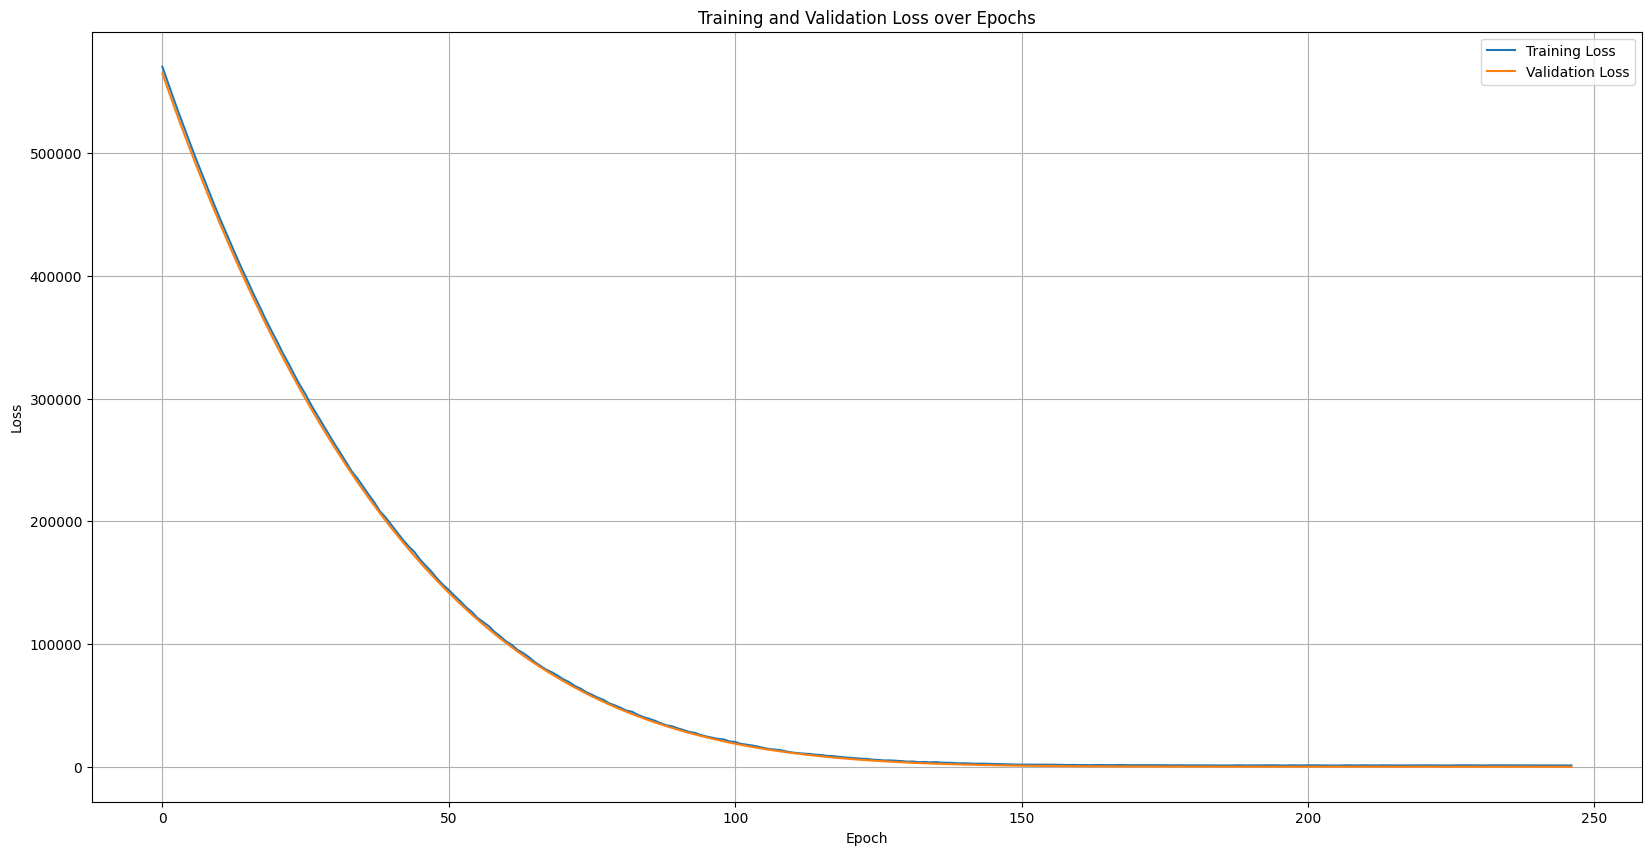

In [19]:
# --- Plotting Training History (Loss) ---
plt.figure(figsize=(20, 10))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Visualize prediction results on validation dataset


--- Generating Predictions for Plotting ---
y_train_pred_np shape: (1114, 7)
y_train_actual_np shape: (1114, 7)
y_valid_pred_np shape: (278, 7)
y_valid_actual_np shape: (278, 7)
y_test_pred_np shape: (310, 7)
y_test_actual_np shape: (310, 7)



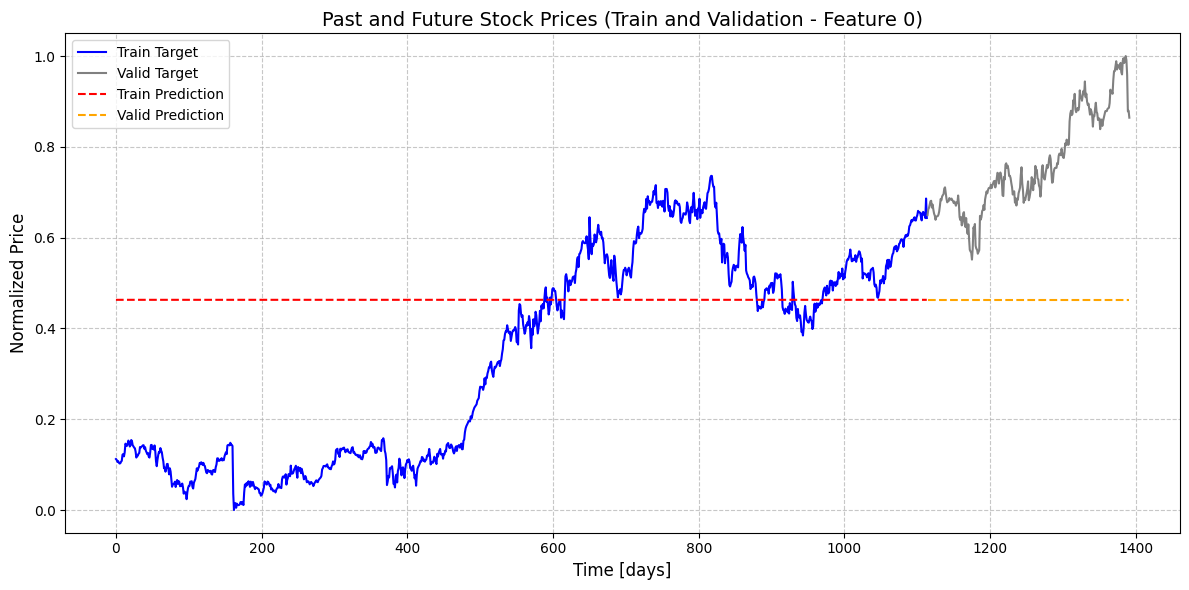


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/: 0.66/0.41



In [20]:
# Create separate DataLoaders for prediction plotting to ensure order
# These are crucial for correct time series plotting when the main loaders are shuffled
train_loader_plot = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader_plot = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_plot = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")
model.eval() # Set model to evaluation mode

# Use _plot loaders to ensure data order for visualization
y_train_pred_list = []
y_train_actual_list = []
with torch.no_grad():
    for inputs, targets in train_loader_plot: # Use train_loader_plot
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_train_pred_list.append(outputs.cpu().numpy())
        y_train_actual_list.append(targets.cpu().numpy())
y_train_pred_np = np.vstack(y_train_pred_list)
y_train_actual_np = np.vstack(y_train_actual_list)

y_valid_pred_list = []
y_valid_actual_list = []
with torch.no_grad():
    for inputs, targets in val_loader_plot: # Use val_loader_plot
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_valid_pred_list.append(outputs.cpu().numpy())
        y_valid_actual_list.append(targets.cpu().numpy())
y_valid_pred_np = np.vstack(y_valid_pred_list)
y_valid_actual_np = np.vstack(y_valid_actual_list)


y_test_pred_list = [] # Keep these for correlation calculation later
y_test_actual_list = [] # Keep these for correlation calculation later
with torch.no_grad():
    for inputs, targets in test_loader_plot: # Use test_loader_plot
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_test_pred_list.append(outputs.cpu().numpy())
        y_test_actual_list.append(targets.cpu().numpy())
y_test_pred_np = np.vstack(y_test_pred_list)
y_test_actual_np = np.vstack(y_test_actual_list)

print(f"y_train_pred_np shape: {y_train_pred_np.shape}")
print(f"y_train_actual_np shape: {y_train_actual_np.shape}")
print(f"y_valid_pred_np shape: {y_valid_pred_np.shape}")
print(f"y_valid_actual_np shape: {y_valid_actual_np.shape}")
print(f"y_test_pred_np shape: {y_test_pred_np.shape}")
print(f"y_test_actual_np shape: {y_test_actual_np.shape}")
print("="*40 + "\n")


# --- Plotting Predictions vs. Actuals (Train and Validation Only) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(12, 6)) # Adjusted overall figure size for a single plot

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Train and Validation - Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                   np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                   np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan


print('Correct sign prediction for close - open price for train/valid/: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid))
print("="*40 + "\n")

# Model Evaluation

## Evaluate model on accuracy metrics for regression (MSE)

In [21]:
# --- Final Test Evaluation ---
print("\n--- Final Test Evaluation ---")
model.eval() # Set model to evaluation mode
test_loss_total = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss_total += loss.item()

final_test_loss = test_loss_total / len(test_loader)
print(f"Final Test Loss (MSE): {final_test_loss:.6f}")

print("\n--- Model Ready for Inference ---")
print("This updated model includes Layer Normalization, Dropout, and the training loop incorporates Early Stopping.")


--- Final Test Evaluation ---
Final Test Loss (MSE): 14.063100

--- Model Ready for Inference ---
This updated model includes Layer Normalization, Dropout, and the training loop incorporates Early Stopping.


## Visualize prediction results on validation and test dataset


--- Generating Predictions for Plotting ---
y_train_pred_np shape: (1114, 7)
y_train_actual_np shape: (1114, 7)
y_valid_pred_np shape: (278, 7)
y_valid_actual_np shape: (278, 7)
y_test_pred_np shape: (310, 7)
y_test_actual_np shape: (310, 7)



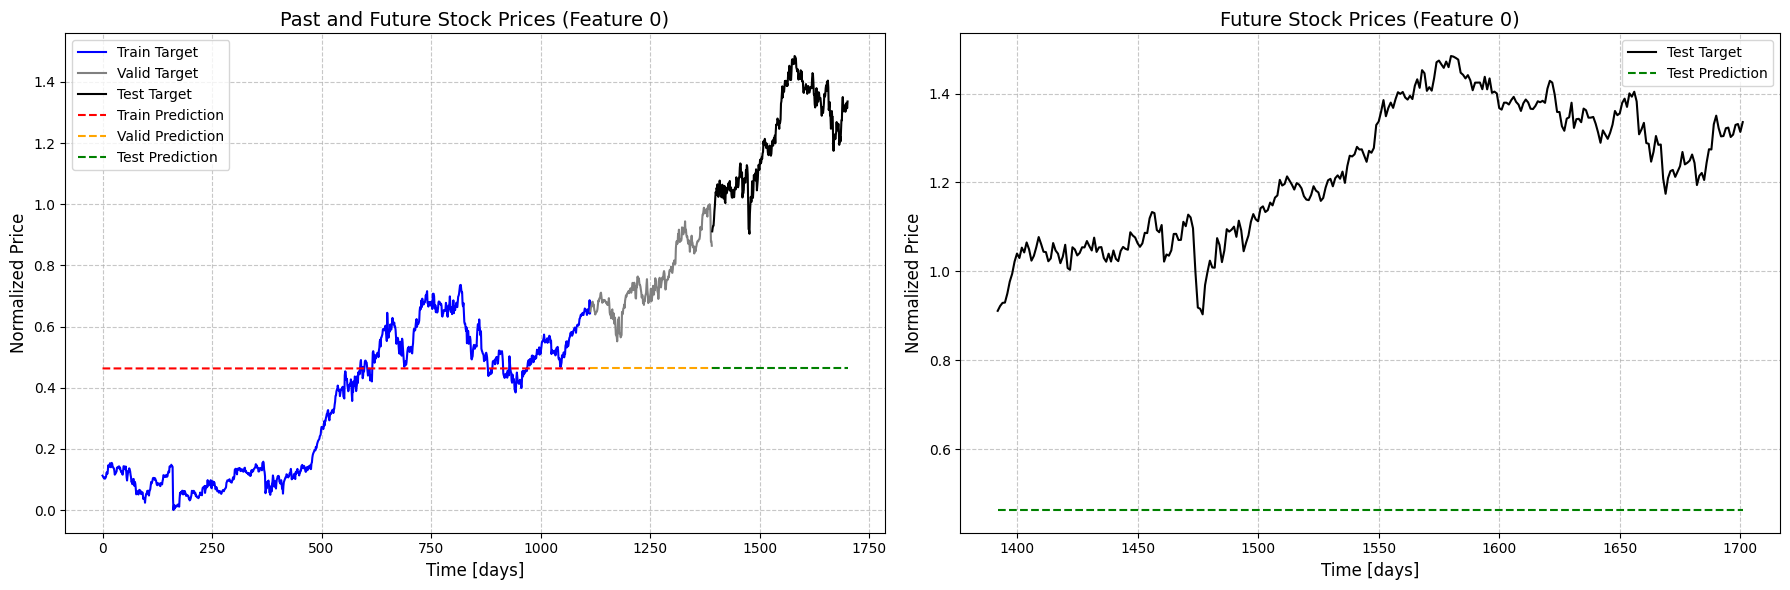


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/test: 0.66/0.41/0.39



In [22]:
# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")
model.eval() # Set model to evaluation mode

# Use _plot loaders to ensure data order for visualization
y_train_pred_list = []
y_train_actual_list = []
with torch.no_grad():
    for inputs, targets in train_loader_plot: # Use train_loader_plot
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_train_pred_list.append(outputs.cpu().numpy())
        y_train_actual_list.append(targets.cpu().numpy())
y_train_pred_np = np.vstack(y_train_pred_list)
y_train_actual_np = np.vstack(y_train_actual_list)

y_valid_pred_list = []
y_valid_actual_list = []
with torch.no_grad():
    for inputs, targets in val_loader_plot: # Use val_loader_plot
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_valid_pred_list.append(outputs.cpu().numpy())
        y_valid_actual_list.append(targets.cpu().numpy())
y_valid_pred_np = np.vstack(y_valid_pred_list)
y_valid_actual_np = np.vstack(y_valid_actual_list)


y_test_pred_list = [] # Keep these for correlation calculation later
y_test_actual_list = [] # Keep these for correlation calculation later
with torch.no_grad():
    for inputs, targets in test_loader_plot: # Use test_loader_plot
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_test_pred_list.append(outputs.cpu().numpy())
        y_test_actual_list.append(targets.cpu().numpy())
y_test_pred_np = np.vstack(y_test_pred_list)
y_test_actual_np = np.vstack(y_test_actual_list)

print(f"y_train_pred_np shape: {y_train_pred_np.shape}")
print(f"y_train_actual_np shape: {y_train_actual_np.shape}")
print(f"y_valid_pred_np shape: {y_valid_pred_np.shape}")
print(f"y_valid_actual_np shape: {y_valid_actual_np.shape}")
print(f"y_test_pred_np shape: {y_test_pred_np.shape}")
print(f"y_test_actual_np shape: {y_test_actual_np.shape}")
print("="*40 + "\n")


# --- Plotting Predictions vs. Actuals ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(18, 6)) # Adjusted overall figure size for two subplots

# Subplot 1: Past and Future Stock Prices (Train, Validation, Test)
plt.subplot(1, 2, 1)

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')
# Corrected the np.arange stop value for test target
plt.plot(np.arange(y_train_actual_np.shape[0] + y_valid_actual_np.shape[0],
                   y_train_actual_np.shape[0] + y_valid_actual_np.shape[0] + y_test_actual_np.shape[0]),
         y_test_actual_np[:,ft], color='black', label='Test Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')
# Corrected the np.arange stop value for test prediction
plt.plot(np.arange(y_train_pred_np.shape[0] + y_valid_pred_np.shape[0],
                   y_train_pred_np.shape[0] + y_valid_pred_np.shape[0] + y_test_pred_np.shape[0]),
         y_test_pred_np[:,ft], color='green', label='Test Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)


# Subplot 2: Future Stock Prices (Test Only)
plt.subplot(1, 2, 2)

# Plot actual test target
# Corrected the np.arange stop value for test target
plt.plot(np.arange(y_train_actual_np.shape[0] + y_valid_actual_np.shape[0],
                   y_train_actual_np.shape[0] + y_valid_actual_np.shape[0] + y_test_actual_np.shape[0]),
         y_test_actual_np[:,ft], color='black', label='Test Target')

# Plot test prediction
# Corrected the np.arange stop value for test prediction
plt.plot(np.arange(y_train_actual_np.shape[0] + y_valid_actual_np.shape[0],
                   y_train_actual_np.shape[0] + y_valid_actual_np.shape[0] + y_test_pred_np.shape[0]),
         y_test_pred_np[:,ft], color='green', label='Test Prediction', linestyle='--')

plt.title('Future Stock Prices (Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                   np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                   np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan

if y_test_actual_np.shape[1] >= 2:
    corr_price_development_test = np.sum(np.equal(np.sign(y_test_actual_np[:,1]-y_test_actual_np[:,0]),
                                                  np.sign(y_test_pred_np[:,1]-y_test_pred_np[:,0])).astype(int)) / y_test_actual_np.shape[0]
else:
    corr_price_development_test = np.nan


print('Correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
print("="*40 + "\n")